# Not Another Dimensionality Reduction Tutorial

Matt Stone  
18 Dec 2019

## 1. Introduction

Dimensionality reduction considers the problem of simplifying high-dimensional data to a smaller, more tractable space. A common source of high-dimensional data in quantitative biology is single-cell RNA-sequencing. Each experiment reports the expression of thousands of genes in thousands of cells. In this context, each cell is an _observation_ with thousands of _features_ - the gene expression measurements. Although these thousand-dimensional vectors are not tractable to work with directly, by reducing their dimensionality we can visualize the cells in two dimensions or improve the performance of analyses such as clustering.

In this tutorial, I hope to provide the following information for a reader who may not be previously familiar with dimensionality reduction:
* Context on the dimensionality reduction problem and its relevance to biological analyses
* Mathematical intuition for two of the most prominent dimensionality reduction algorithms - PCA and t-SNE
* Demonstrating the application of these and other algorithms to real biological data with Python 
* Summarizing the strengths and weaknesses of these algorithms

## 2. Background

Dimensionality reduction has two primary applications - visualization and clustering.

We often want to visualize our data to determine if there are any interesting relationships in our data. However, when creating visualizations we're generally limited to two dimensions. If our data points are of a higher dimension, we can't plot them directly, and instead want to find a corresponding 2-D point that is a "good-enough" approximation of the original high-dimensional vector. Ideally, we want to find a 2-D approximation that preserves most of the structure in the original data. That is, if two points are nearby each other in the original high-dimensional space, we'd like them to remain near each other in 2-D space so we can "see" their similarity. 

Let's look at a simple 3D example. Suppose our data consists of two rings, one floating above the other. 

<center><img src='figs/circles.png' height=400></center>

If we rotate the data around a bit while staying in 3D space, we can see that it should be possible to separate the points from each other. Specifically, if we look at these data from the front or the side, we can see that the data exists in two "layers", while if we look at the the data from the top, we can see the two circles.

<center><img src='figs/circles_rotated.png' height=400></center>

This hopefully provides some intuition for _linear_ dimensionality reduction. In general, we choose some plane in 2D space, and project each data point onto the nearest point in this plane. 

Here, a very simple linear algorithm is to choose two of our coordinates to keep (X and Y) and one to discard (Z). This preserves the circular structure of the red and blue clusters, although we lose the information we had about how far apart these data were vertically. 

<center><img src='figs/projection.png' height=400></center>

Visualization can be helpful when trying to explore some algorithmic result. For example, when evaluating the Garnett algorithm, the authors created a figure of the cells colored by their cell type assignments in order to demonstrate that these cell types were generally coherent within each visible cluster.

This brings us to our second application - clustering. When we visualize our data in 2-D space, we often observe some visible structure, or grouping of our data points. There are many algorithms which formalize the problem of identifying clusters in a dataset. However, these algorithms require some quantifiable measure of similarity between data points. Typically, this is Euclidean distance, or the L2-norm:

\begin{equation*}
d(x, y) = \lVert x - y \rVert_2 = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}
\end{equation*}

However, traditional distance doesn't behave as expected in high dimensions - distances generally end up being quite large and all points look far away from each other. We can therefore use dimensionality reduction as a preprocessing step before applying a clustering algorithm. We don't have to reduce all the way to two dimensions, but we can choose an intermediate size (20-30 dimensions) where distance metrics behave reasonably well. 

Preserving structure is especially important when considering dimensionality reduction algorithms for clustering. We want to preserve both local distances (whether two points are similar) and global distances (whether two clusters are similar) in order to accurately analyze any structure in our dataset.

## 3. Dimensionality reduction algorithms


### 3.1 Principal components analysis (PCA)

PCA is a very common and popular dimensionality reduction technique. It is a _linear_ reduction algorithm, which means that it chooses some plane (or line, in the 1-D case), and "squashes" the original data to that plane by mapping every data point to its closest point in the plane.

To choose the "best" plane, PCA identifies the vector through the data which maximizes the variance of the data after the points are projected onto it, then successively finds  orthogonal vectors which maximize the remaining variance. Intuitively, if your data are Gaussian and in an ellipsoid shape, PCA will identify first the major axis and then the minor axis of the ellipsis.

Let's consider a simple example. We'll look at the following 2-dimensional dataset, and explore how PCA would reduce it to a single dimension.

<center><img src='figs/pca_data.png' height=400></center>

We can choose any line we like, and project the points onto it. By "project", we mean "choose the point on the line that's closest to our actual point." After projecting the points onto a line, we have a set of 1-dimensional points, from which we can compute familiar summary statistics such as mean or variance.

<center><img src='figs/pca_steps.png' height=400></center>

How do we pick a "best" line? PCA chooses the line that maximizes the variance of the projected points. For example, consider projecting our data onto the lines $y=0$, $y=-x$, and $y=x$.

<center><img src='figs/pca_compare_projections.png' height=400></center>

Hopefully it's clear that when we project our data onto $y=-x$, the projected points are packed very tightly together, and therefore have less variance, while when we project our data onto $y=x$, the projected points are spread out and have much greater variance.

And, if we plot the distribution of the 1-D projections, we can see that projecting onto $y=x$ maximizes the variance of the projection.

<center><img src='figs/pca_compare_variance.png' height=400></center>

This line is the _first principal component_. If we want to obtain additional principal components, or dimensions, we can pick the line that is orthogonal to our first component and maximizes the remaining variance. In the 2-D setting, this means just choosing the line perpendicular to the line we've already chosen.

In [ ]:
TODO: notes on 

### 3.2 t-distributed stochastic neighbor embedding (t-SNE)

The t-SNE algorithm is a more recent algorithm and is especially popular in single-cell applications. t-SNE is a nonlinear algorithm, and belongs to the family of "manifold learning" algorithms. Broadly, these algorithms assume that the high-dimensional data exists on a lower-dimensional "surface", and attempt to approximate this surface. Rather than trying to capture the maximal global variance, as in PCA, nonlinear algorithms often assume that nearby points represent local neighborhoods, and try to preserve the structure of these local neighborhoods.

For example, if we had 3-D points representing every city on the planet, the points would roughly correspond to the surface of a sphere. Rather than linearly "squashing" these points onto a circle, which would place cities from opposite sides of the globe next to each other, a nonlinear algorithm would try to build a local map of a state or country, then stitch the local maps together. 

The t-SNE algorithm assumes that a single data point $x_i$ and its neighbors are drawn from a Gaussian (aka normal) distribution centered on $x_i$. The algorithm finds a 2-dimensional embedding of the data that minimizes the divergence between the high-dimensional distribution and a Student's t-distribution over the 2-D points.

The authors define the following conditional probability distribution over every data point:

$$p_{j \mid i} = \frac{\exp \left( - \lVert x_i - x_j \rVert^2 / 2 \sigma_i^2 \right)}{\sum\limits_{k \ne i} \exp \left( - \lVert x_i - x_k \rVert^2 / 2 \sigma_i^2 \right)}$$

This equation defines a similarity between $x_j$ and $x_i$, relative to $x_i$. (Note that this means there is a different similarity between the two data points relative to $x_j$.) 

The numerator is a common similarity measure in machine learning called the _radial basis function_. It computes the Euclidean distance between two points, and scales the distance to between 0 and 1. Note that if the two points are the same, $e^0=1$, and if they are very far apart, $\frac{1}{e^n}$ becomes very close to zero for large $n$.

The denominator sums these values over all datapoints in order to normalize these values to a valid probability distribution (the probabilities $p_{j \mid i}$ for a given $i$ should sum to 1).

The probability $p_{j \mid i}$ is the _conditional_ probability of observing $j$ from $i$. To obtain the _joint_ probability $p_{ij}$, the probability of observing $i$ and $j$ together, t-SNE symmetrizes the probabilities by averaging them and scaling by the number of data points.

$$p_{ij} = \frac{p_{i \mid j} + p_{j \mid i}}{2n}$$

This probability $p_{ij}$ is the joint probability of two data points in the high-dimensional setting. The algorithm defines the joint probability in the lower-dimensional setting $q_{ij}$ with a Student t-distribution with one degree of freedom:

$$q_{ij} = \frac{\left(1 + \lVert y_i - y_j \rVert ^2 \right)^{-1}}{\sum \limits_{k \ne l} \left(1 + \lVert y_k - y_l \rVert ^2 \right)^{-1}} $$

Note that this is structurally similar to the similarity measure we used in the high-dimensional space. Again we're computing the Euclidean distance between two points, but we're applying a different transformation to obtain a similarity measure. 

Looking at the numerator, if two data points are the same, their distance is zero and this value becomes 1. If two data points are very far apart, taking 1 over this distance produces a value very close to zero. 

In the denominator, we're summing these similarity measures over all data points, so we define a valid joint probability distribution (all the probabilities $q_{ij}$ sum to 1).

The t-SNE algorithm searches over possible embeddings to find one where $q$ is most similar to $p$. The algorithm uses a measure called the Kullback-Leibler divergence to quantify the difference between the two distributions.

Let's look at an example Swiss roll dataset. The Swiss roll is a 2-D surface curled up in 3-D space. The figure on the left helps visualize the structure of this data; the next example will use the subset of 100 data points on the right for clarity.

<center><img src='figs/swiss_roll_data.png' height=400></center>

What does a joint probability distribution look like? The distribution defines a probability between each pair of points $x_i$ and $x_j$, so we can visualize this as a 3-D surface. Points on the X/Y plane along the bottom of the figure represent different pairs of data points, and the vertical height of the surface represents the corresponding joint probability of each pair. 

Here, I've plotted the joint probability distribution of the 100 3-D points in the Swiss roll, as defined by the t-SNE algorithm. 

<center><img src='figs/tSNE_3D_joint.png' height=400></center>

The shape of this distribution makes intuitive sense. There's a sort of ridge along the diagonal, showing that points which were neighbors in the 3-D space share a high joint probability. ($x_0$ is at one end of the Swiss roll, and $x_{100}$ is at the other end.)

Now let's look at some possible projections. Let's compare the naive embedding where we simply discard one of our coordinates, a PCA embedding, and a t-SNE embedding.

<center><img src='figs/tSNE_compare_embeddings.png' height=400></center>

The naive embedding is noisy as we expect. We can see the PCA accurately captures most of the "shape" of the Swiss roll, but around the lower middle of the embedding there are many points from the dark blue end of the roll that are close to points from the yellow/green end (which may confuse a clustering algorithm). In the t-SNE plot we can see more of an "unrolling", with the points roughly curving along the flattened surface of the roll.

Now let's look at the joint distributions ($q$) corresponding to each of these embeddings.

<center><img src='figs/tSNE_compare_q.png' height=400></center>

These are a little trickier to make out (author's note: using fewer data points made the figures easier to read, as above, but the corresponding 2-D joint distributions weren't sufficiently different. This did make me wonder about how many points are sufficient for each algorithm.), but you should be able to see that the distributions obtained from the naive and PCA embeddings are more uniform. They have more and lower peaks, while the distribution obtained from t-SNE has fewer but stronger peaks.

### 3.3 Uniform manifold approximation and projection (UMAP)

The UMAP algorithm builds a nearest-neighbor graph from the high dimensional data, and tries to learn a low-dimensional embedding whose nearest-neighbor graph has a similar topology. More formally, the algorithm normalizes distances for the nearest-neighbor graph based on how far away a point is from its nearest neighbor, and minimizes something called cross entropy between the topology of the high and low dimensional graphs.

## 4. Demonstration of PCA, t-SNE, and UMAP

In [10]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

### Example data &mdash; Tran et al.

To demonstrate these dimensionality reduction techniques, I'll be using single-cell RNA-seq data from a recent study of reprogramming mouse iPSC lines published by [Tran et al.](https://www.cell.com/cell-reports/fulltext/S2211-1247(19)30529-7) (GEO accession [GSE108222](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE108222)). 

The experiment sequenced the expression profiles of a sample mouse embryonic fibroblasts (MEFs), along with the the expresion of MEFs after a iPSC reprogramming protocol (A2S refers to the growth medium of the reprogrammed cells; reprogrammed cells were sampled after 2, 4, and 6 days). In addition, the authors sequenced the expression of a sample of mouse embryonic stem cells (mESCs), to compare with the reprogrammed cells.

This matrix contains expression levels of 6,618 genes in 2,369 cells, sampled at 4 timepoints with 2 replicate cell lines. The expression data has previously been depth-normalized and square-root transformed, so we will work with the example matrix directly. 

We can take a quick look at the first few lines and columns of the matrix to get a sense for what the data looks like. The rows are labeled with gene names, and the columns are labeled with cell IDs, which include the timepoint (e.g. MEF Day0 Rep1) and the unique molecular identifier (UMI) for the droplet.

In [11]:
expr = pd.read_csv('data/sridharan_A2S.csv.gz', index_col=0)    # Load expression matrix as Pandas dataframe
print(expr.shape)                                          # Print number of rows and columns
expr.iloc[:5, :3]                                          # Display first 5 rows and first 3 columns

(6618, 2369)


,MEFDay0Rep1_gctgaggtacaggagctt,MEFDay0Rep1_atagcgcggtccacccaa,MEFDay0Rep1_tgcggtgaaatagctccc
Gene,,,
1110004E09Rik,0.508184,0.625024,0.447522
1110051M20Rik,0.000000,0.625024,0.000000
2210016L21Rik,0.803510,0.765495,1.184033
2300002M23Rik,0.000000,0.000000,0.000000
2900026A02Rik,0.803510,0.625024,0.447522


We can also view the full expression matrix as a heatmap to get a sense of what the data looks like. We can see that some genes (rows) are expressed in most cells (bright yellow rows), and the data is generally somewhat noisy (even high expressed genes have empty values in some cells, overall the matrix looks sparse or dotty).

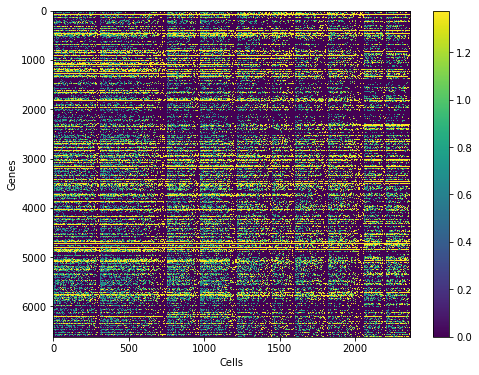

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))          # Create a matplotlib figure with 1 plot

im = ax.imshow(expr.values,                           # Plot a heatmap on the figure
               aspect='auto',                         # Scale the heatmap to the size of the figure
               vmin=0,                                # Color scale starts at 0
               vmax=np.quantile(expr.values, 0.9),    # Color scale ends at 90th pctile (clip high-expressed genes)
               cmap='viridis')                        # Use a perceptually uniform color map

ax.set_xlabel("Cells")
ax.set_ylabel("Genes")
ax.figure.colorbar(im)                                # Show range of values corresponding to color scale

### PCA

Let's start by obtaining a PCA of our expression data. We will use the [scikit-learn](https://scikit-learn.org/stable/index.html) implementation (full documentation available [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)).

In [13]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)    # Create a PCA object/model
pca.fit(expr.T)                            # Fit the PCA model to our expression matrix
                                           #  (Note that we transpose the matrix so genes are features)
pca_embedding = pca.transform(expr.T)      # Reduce the expression matrix to the top 2 components

Let's walk through this code. 

Scikit-learn algorithms are generally provided as methods to _classes_. We first instantiate a PCA object, or model, with the desired parameters. Here, we are only specifying the argument `n_components`, which tells the model the number of dimensions we want to reduce to.

```
pca = decomposition.PCA(n_components=2)
```

Next, we want to fit the model to our data. Scikit-learn objects generally have a `fit` method that takes a matrix of data. Remember that our expression matrix `expr` has genes as rows and cells as columns. Scikit-learn algorithms assume that rows correspond to observations and columns correspond to features (or variables), so we transpose our matrix before fitting the model.
```
pca.fit(expr.T)
```

Finally, we want to transform our data. Again, Scikit-learn objects have a general method called `transform` that handles this for us, and we want to transpose our (genes x cells) matrix before transformation. 
```
pca_embedding = pca.transform(expr.T)
```

And, if we look at the dimensions of our matrices, we can see that our PCA has successfully reduced the raw expression data from 6,618 dimensions (number of genes) to 2 dimensions (principal components).

In [14]:
print(expr.T.shape)
print(pca_embedding.shape)

(2369, 6618)
(2369, 2)


Now, we can view our cells in a 2-dimensional scatter plot. Here, every point in the scatter plot is a cell, the x-axis corresponds to the first principal component, and the y-axis corresponds to the second.

Text(0, 0.5, 'PC2')

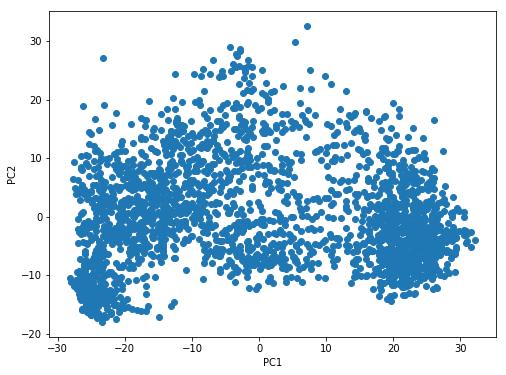

In [15]:
fig, ax = plt.subplots(1, 1, 
                       figsize=(8, 6))    

ax.scatter(pca_embedding[:, 0],           # Scatter plot (x-values first)
           pca_embedding[:, 1])           # y-values

ax.set_xlabel('PC1')                      # Label axes with first/second principal components
ax.set_ylabel('PC2')

But this is kind of a boring figure. Generally, we want to reduce the dimensionality of our data so we can visualize some feature of interest across the cells. For example, here we could color the cells based on their timepoint/cell type (ignoring cell line replicates for now).

We'll load a table that includes these labels:

In [16]:
pdata = pd.read_table('data/pheno_data.cell_filtered.txt', index_col=0)
pdata.head()

,Timepoint:Replicate,Timepoint,Replicate
MEFDay0Rep1_gctgaggtacaggagctt,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_atagcgcggtccacccaa,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_tgcggtgaaatagctccc,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_ggattggccagagtcggc,MEFDay0Rep1,MEFDay0,Rep1
MEFDay0Rep1_gatcaagtcggcgtttca,MEFDay0Rep1,MEFDay0,Rep1


And then we'll make another scatter plot where each timepoint is colored separately.

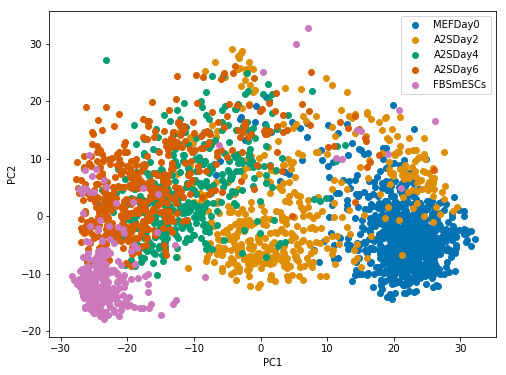

In [17]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(pca_embedding[idx, 0],               # First component of the current cells (x-values)
               pca_embedding[idx, 1],               # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second principal components
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

This is more interesting! We can start seeing a temporal progression from the initial fibroblasts on the right, through the sampled timepoints of the differentiating cells, ending with "final" embryonic stem cells on the left.

### Cleaner code

Before moving on to the other sections, I am going to introduce two shortcuts for the above code that will be useful as we look at the other algorithms.

The first shortcut is the `fit_transform` method. Like the `fit` and `transform` methods, it's available in most Scikit-learn objects, and it is a convenience method that combines model fitting and transformation into one step. It takes the data matrix like the other functions, fits the model to the data, and returns the transformed data.

In [18]:
pca = decomposition.PCA(n_components=2)      # Create a PCA object/model
pca_embedding = pca.fit_transform(expr.T)    # Fit the model and transform the expression matrix

The second shortcut is that we don't have to store the PCA model in its own variable. We can simply instantiate the model and then call `fit_transform` on it directly. This idea of "chaining" methods is common in the Python data science stack and you will often see it applied to Numpy arrays, Pandas DataFrames, or Scikit-learn pipelines. 

So we can reduce our dimensionality reduction to a single line of code:

In [19]:
pca_embedding = decomposition.PCA(n_components=2).fit_transform(expr.T)

### t-SNE

We will use [scikit-learn's](https://scikit-learn.org/stable/index.html) implementation of t-SNE. The full documentation for their implementation is available [here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html).

Obtaining a t-SNE embedding of the cells is relatively straightforward, with only a few lines of code:

In [20]:
from sklearn import manifold
from sklearn import decomposition

pca_intermediate = decomposition.PCA(n_components=30).fit_transform(expr.T)
tSNE_embedding = manifold.TSNE(n_components=2).fit_transform(pca_intermediate)

Let's walk through these two lines of code. 

The first should be familiar from our use of PCA in the last section. We're using PCA to reduce the raw expression to the top 30 principal components.

In the second line, instead of using the `decomposition.PCA` class to run a PCA, we're using Scikit-learn's `manifold.TSNE` class to run t-SNE. Note that besides the different class, the syntax is otherwise the same &ndash; we need to specify `n_components` and can use the `fit_transform` method.

Now, why are we running a PCA before t-SNE? The t-SNE algorithm is relatively slow, so it's recommended to "partially" reduce the dimensions with another algorithm, such as PCA, before applying t-SNE. Here, we are using PCA to reduce our expression data to the top 30 principal components, and then applying t-SNE to this (2369 x 30) matrix.

And again we can sanity check our dimensions to confirm that we have two dimensions for each of our 2,369 cells:

In [21]:
print(expr.T.shape)
print(pca_intermediate.shape)
print(tSNE_embedding.shape)

(2369, 6618)
(2369, 30)
(2369, 2)


Now, we'll plot the t-SNE embedding of our points using the same code as above. The only difference is that we are now using the t-SNE coordinates instead of the PCA coordinates.

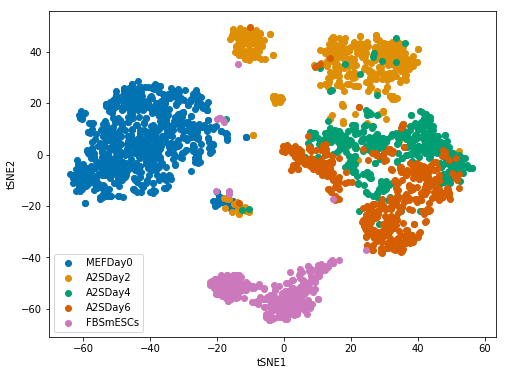

In [22]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(tSNE_embedding[idx, 0],              # First component of the current cells (x-values)
               tSNE_embedding[idx, 1],              # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second components
ax.set_xlabel('tSNE1')
ax.set_ylabel('tSNE2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

### UMAP

Finally, we'll try using UMAP. UMAP is not packaged with scikit-learn like the other algorithms, but is available as [its own package](https://umap-learn.readthedocs.io/en/latest/). 

In [23]:
import umap

umap_embedding = umap.UMAP(n_components=2, random_state=149).fit_transform(expr.T)

Even though UMAP is a separate package from scikit-learn, the syntax is compatible with the scikit-learn classes we've seen so far. We create a `umap.UMAP` class, specifying that we want to reduce to two dimensions, and then we call `fit_transform` on the expression matrix to obtain the 2-D embedding.

Note the additional argument `random_state`. UMAP is a stochastic, not deterministic, algorithm, so its output can change from run to run. By setting a fixed random state (equivalent to R's `set.seed`), we can keep its output reproducible.

Again we sanity check our dimensions:

In [24]:
print(expr.T.shape)
print(umap_embedding.shape)

(2369, 6618)
(2369, 2)


And plot the embedding:

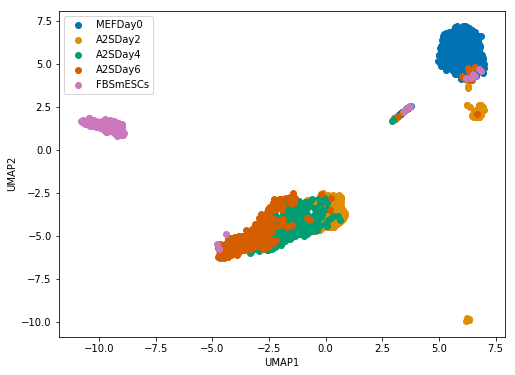

In [25]:
# Figure setup
fig, ax = plt.subplots(1, 1, figsize=(8, 6))    # Figure with one plot again
palette = sns.color_palette('colorblind')       # Keep it colorblind-friendly!

# Scatter plots - we plot the cells from each timepoint separately
# so we can give them different colors and labels
for i, timepoint in enumerate(pdata.Timepoint.unique()):
    idx = np.where(pdata.Timepoint == timepoint)    # Get the indices of the cells at the given timepoint
    ax.scatter(umap_embedding[idx, 0],              # First component of the current cells (x-values)
               umap_embedding[idx, 1],              # Second component of the current cells (y-values)
               c=[palette[i]],                      # Palette is list of colors - cycle through with each timepoint
               label=timepoint)                     # Label each group of cells with timepoint - for legend

# Label axes with first/second components
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')

# Matplotlib automagically makes legend based on labels provided above
ax.legend()                                

This is a potentially interesting view of the data - UMAP isolates the original fibroblasts as its own cluster, clusters all of the reprogrammed (A2S) cells together while preserving the time series structure, and isolates the mESCs. This is interesting because it appears that the reprogramming isn't yielding cells that are as similar to the mESCs as one might hope. Additionally, UMAP appears to be in some ways combining the best of PCA and t-SNE - the samples are being cleanly clustered in a way that's consistent with biological expectations, as in t-SNE, but the embedding appears to be maintaining some information about the temporal relationship between these samples, as in PCA.

## 5. Summary

Dimensionality reduction represents an important solution for visualizing and clustering large biological data. Broadly, dimensionality algorithms try to identify the "best" low-dimensional representation of a high-dimensional dataset. The strategies by which these algorithms choose a "best" representation vary, as do the assumptions the algorithms make about the data's structure. 

Linear algorithms project the high-dimensional data directly onto the nearest point in some plane ("squashing"), while nonlinear algorithms typically try to capture local similarity in the data and project "neighborhoods" together. We saw an example of each class of algorithm - PCA chooses the plane which maximizes the variance within the projected data, while t-SNE chooses an embedding where a probability distribution over the projected data is the most similar to the high-dimensional data. In general, linear algorithms provide more intuitively interpretable embeddings, in terms of understanding the relationship between the coordinates of the embedding and the initial space, although the complexity of biological datasets is often well-suited to nonlinear approaches.

We also saw applications of these algorithms to an example scRNA-seq dataset, consisting of a time-series of cells undergoing reprogramming to an induced stem cell state. This provided example Python code to apply dimensionality reduction algorithms, and hopefully familiarized the reader with the `.fit_transform` syntax that is common to most Python implementations of dimensionality reduction algorithms, along with some examples of visualizing the dimensionally reduced data. Additionally, in this section we saw that PCA was generally able to identify the temporal nature of the data as the first component, although the cell types overlapped each other. The t-SNE projection yielded more discrete clusters, but it was less feasible to interpret their relationship between each other. The UMAP algorithm appeared to generate an embedding that demonstrated both these advantages. 

## 6. References

### Background
* Aggarwal, Charu C., Alexander Hinneburg, and Daniel A. Keim. "On the surprising behavior of distance metrics in high dimensional space." International conference on database theory. Springer, Berlin, Heidelberg, 2001.
* Nguyen, Lan Huong, and Susan Holmes. "Ten quick tips for effective dimensionality reduction." PLOS Computational Biology 15.6 (2019): e1006907.
* Tian, Luyi, et al. "Benchmarking single cell RNA-sequencing analysis pipelines using mixture control experiments." Nature methods (2019): 1.

 
### Algorithms

* Discussion of PCA draws heavily upon lecture notes from ECE 532 (Spring 2019) with Dr. Po-Ling Loh, along with the [Wikipedia page](https://en.wikipedia.org/wiki/Principal_component_analysis).
* Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9.Nov (2008): 2579-2605.
* [How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)
* [An Illustrated Introduction to the t-SNE Algorithm](https://www.oreilly.com/learning/an-illustrated-introduction-to-the-t-sne-algorithm)
* McInnes, Leland, John Healy, and James Melville. "UMAP: Uniform manifold approximation and projection for dimension reduction." arXiv preprint arXiv:1802.03426 (2018).
* Becht, Etienne, et al. "Dimensionality reduction for visualizing single-cell data using UMAP." Nature biotechnology 37.1 (2019): 38.
* [Understanding UMAP](https://pair-code.github.io/understanding-umap/)

### Demonstration

* Tran, Khoa A., et al. "Defining Reprogramming Checkpoints from Single-Cell Analyses of Induced Pluripotency." Cell reports 27.6 (2019): 1726-1741.
* Python packages:
    * [Scikit-learn](https://scikit-learn.org/stable/)
    * [Pandas](https://pandas.pydata.org)
    * [Matplotlib](https://matplotlib.org)
    * [Seaborn](https://seaborn.pydata.org)
    * [UMAP](https://umap-learn.readthedocs.io/en/latest/)

(Apologies for the poor reference formatting, I haven't figured out a good solution for citations/bibliography in Jupyter yet.)